In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

import uncertainties as un
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values, std_devs
err = std_devs
nom = nominal_values

In [228]:
df = pd.read_pickle('data/processed_LiDataFull.pkl')  # use pickle to preserve uncertainty info
sdf = pd.read_pickle('data/processed_LiDataSummary.pkl')  # use pickle to preserve uncertainty info
figdir = 'figs/'  # location to save figures

def savefig(fig, name):
    fig.savefig(os.path.join(figdir, name + '.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(figdir, name + '.pdf'))

## Plot Parameters

In [154]:
# database = 'minteq.v4'  # which solution chemistry calculation to use -- minteq.v4 or pitzer
database = 'pitzer'  # which solution chemistry calculation to use -- minteq.v4 or pitzer

cdict = {
    'Control': 'C1',
    'T': 'grey',
    'DIC': 'C2',
    'pH': 'C0'
}

## Results 0: Experimental Matrix

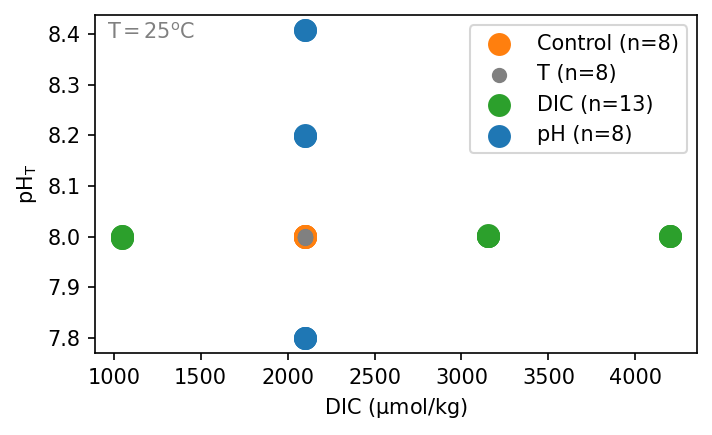

In [155]:
fig, ax = plt.subplots(1, 1)

for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    s = 100
    if e == 'T':
        s = 40
    ax.scatter(df.loc[ind, (database, 'C(mol/kgw)')] * 1e6, df.loc[ind, (database, 'pH')], label=f'{e} (n={sum(ind)})', color=c, s=s)

ax.text(.02, .98, '$T=25^oC$', va='top', ha='left', color=(.5,.5,.5), transform=ax.transAxes)
ax.legend(fontsize=10)

ax.set_ylabel('$pH_T$')
ax.set_xlabel('DIC ($\mu mol/kg$)')

fig.tight_layout()

savefig(fig, 'S1_Matrix')

## Results 1: Individual effects

In [156]:
def line(x, m, c):
    return x * m + c

def fit_line(x, y):
    nona = ~np.isnan(x) & ~np.isnan(y)
    
    return un.correlated_values(*curve_fit(line, x[nona], y[nona]))

def plot_line(ax, coef, **kwargs):
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    
    xn = np.linspace(*xlim, 50)
    yn = line(xn, *coef)
    
    ax.plot(xn, nominal_values(yn), **kwargs)
    ax.fill_between(xn, nominal_values(yn) - 1.96 * std_devs(yn), nominal_values(yn) + 1.96 * std_devs(yn), alpha=0.2, **kwargs, lw=0)

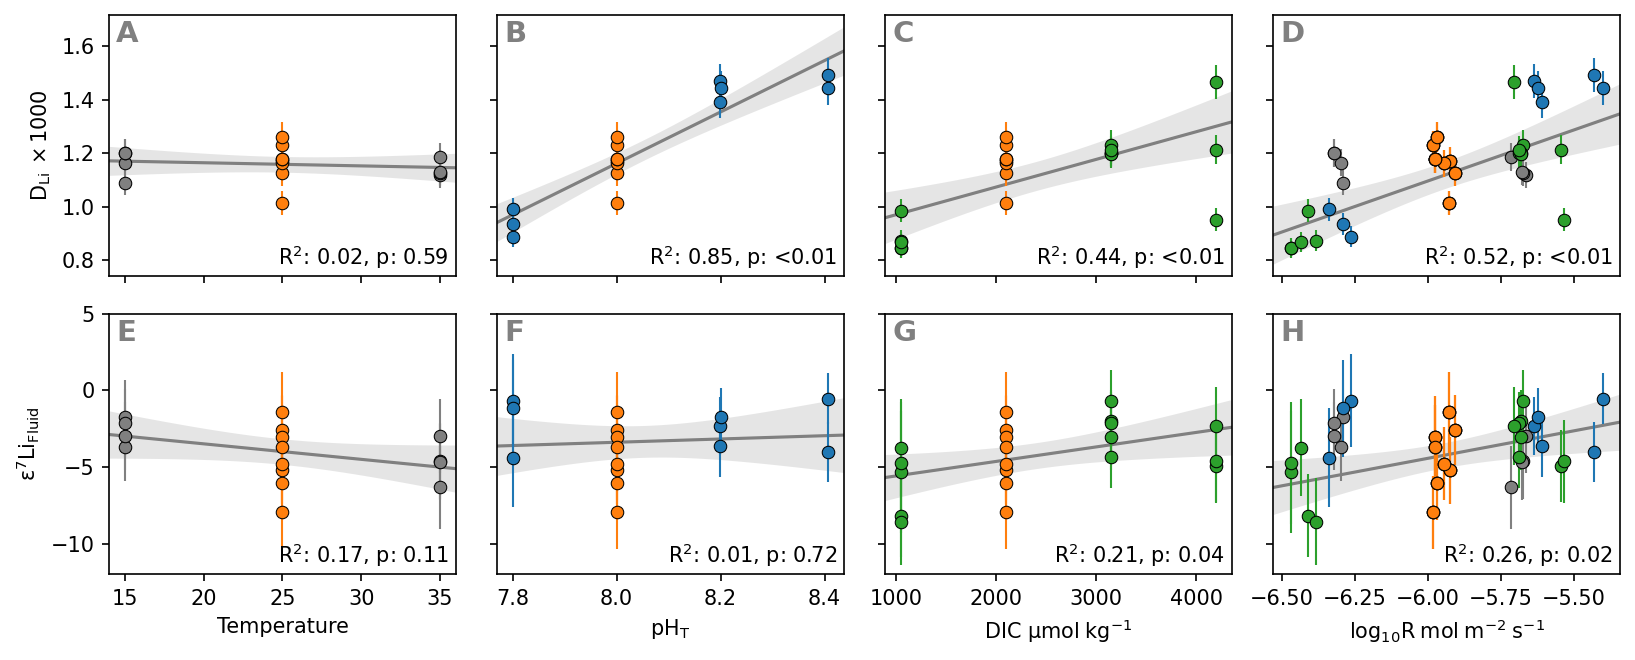

In [157]:
fig, axs = plt.subplots(2, 4, sharey='row', sharex='col', figsize=[11, 4.5])
# fig, axs = plt.subplots(2, 5, figsize=(14, 5), sharey='row', sharex='col')

axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\epsilon^7Li_{Fluid}$')
rdax, rpax = axs[:, -1]

for i, xvar in enumerate(['temp(C)', 'pH', 'C(mol/kgw)']):
    dax, pax = axs.T[i]
    if xvar == 'C(mol/kgw)':
        m = 1e6
        v = 'DIC'
    elif xvar == 'pH':
        m = 1
        v = 'pH'
    elif xvar == 'temp(C)':
        m = 1
        v = 'T'
    else:
        vind = np.ones(df.shape[0], dtype=bool)
        m = 1

    cind = df.labels.Experiment.str.contains('Control')
    vind = df.labels.Experiment.str.contains(v)
    color = cdict[v]
    lw=0.5
    
    for ind, c in zip([vind, cind], [color, cdict['Control']]):
        dax.errorbar(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     xerr=err(df.loc[ind, (database, xvar)]) * m, yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=0, elinewidth=1, color=c, zorder=-1)
        dax.scatter(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                    lw=lw, edgecolor='k', color=c, zorder=1)
                
        pax.errorbar(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     xerr=err(df.loc[ind, (database, xvar)]) * m, yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     lw=0, elinewidth=1, color=c, zorder=-1)
        pax.scatter(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                    lw=lw, edgecolor='k', color=c, zorder=1)
        
        rdax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                      xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                      lw=0, elinewidth=1, color=c, zorder=-1)
        rdax.scatter(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=lw, edgecolor='k', color=c, zorder=1)
        rpax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                      xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                      lw=0, elinewidth=1, color=c, zorder=-1)
        rpax.scatter(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     lw=lw, edgecolor='k', color=c, zorder=1)
        
    dp = fit_line(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
    dreg = stats.linregress(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
    plot_line(dax, dp, zorder=-3, color='gray')
    ptext = f'{dreg.pvalue:.2f}' if dreg.pvalue > 0.01 else '<0.01'
    dax.text(0.98, 0.02, f'$R^2$: {dreg.rvalue**2:.2f}, p: {ptext}', transform=dax.transAxes, ha='right', va='bottom')
    
    pp = fit_line(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
    preg = stats.linregress(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
    plot_line(pax, pp, zorder=-3, color='gray')
    ptext = f'{preg.pvalue:.2f}' if preg.pvalue > 0.01 else '<0.01'
    pax.text(0.98, 0.02, f'$R^2$: {preg.rvalue**2:.2f}, p: {ptext}', transform=pax.transAxes, ha='right', va='bottom')
    
axs[1,0].set_xlabel('Temperature')
axs[1,1].set_xlabel('$pH_T$')
axs[1,2].set_xlabel('DIC $\mu mol~kg^{-1}$')
axs[1,3].set_xlabel('$log_{10}R~mol~m^{-2}~s^{-1}$')

dp = fit_line(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
dreg = stats.linregress(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
plot_line(rdax, dp, zorder=-3, color='gray')
ptext = f'{dreg.pvalue:.2f}' if dreg.pvalue > 0.01 else '<0.01'
rdax.text(0.98, 0.02, f'$R^2$: {dreg.rvalue**2:.2f}, p: {ptext}', transform=rdax.transAxes, ha='right', va='bottom')

pp = fit_line(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
preg = stats.linregress(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
plot_line(rpax, pp, zorder=-3, color='gray')
ptext = f'{preg.pvalue:.2f}' if preg.pvalue > 0.01 else '<0.01'
rpax.text(0.98, 0.02, f'$R^2$: {preg.rvalue**2:.2f}, p: {ptext}', transform=rpax.transAxes, ha='right', va='bottom')

rpax.set_ylim(-12, 5)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

# axs[1,0].set_ylim(-9, 0)
fig.tight_layout()

savefig(fig, '01_IndividualEffects')

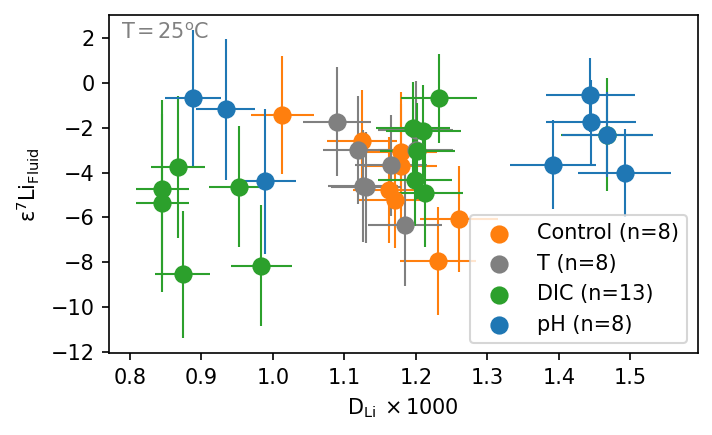

In [158]:
fig, ax = plt.subplots(1, 1)

for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    s = 60

    ax.scatter(nom(df.loc[ind, ('OG', 'DLi')]) * 1e3, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]), label=f'{e} (n={sum(ind)})', color=c, s=s)
    ax.errorbar(nom(df.loc[ind, ('OG', 'DLi')]) * 1e3, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                xerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3, yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                lw=0, elinewidth=1, color=c, zorder=-1)
    
ax.text(.02, .98, '$T=25^oC$', va='top', ha='left', color=(.5,.5,.5), transform=ax.transAxes)
ax.legend(fontsize=10)

ax.set_ylabel('$\epsilon^7Li_{Fluid}$')
ax.set_xlabel('$D_{Li}\ \\times 1000$')

fig.tight_layout()

## 2. Comparison to Previous

In [159]:
lit = pd.read_pickle('data/processed_LiDataLiterature.pkl')

rdict = {
    'Gabitov2019': 'Gabitov et al. (2019)',
    'Langer2015': 'Langer et al. (2015)', 
    'Marriott2004a': 'Mariott et al. (2004a)', 
    'Marriott2004b': 'Mariott et al. (2004b)', 
    'Roberts2018': 'Roberts et al. (2018)', 
    'Vigier2015': 'Vigier et al. (2015)',
    'Fuger2019': 'Fuger et al. (2019)'
}

mdict = {
    'Gabitov2019': ('C2', '^'),
    'Langer2015': ('C5', 'd'),
    'Marriott2004a': ('C4', '<'),
    'Marriott2004b': ('C4', '>'),
    'Roberts2018': ('C6', '+'),
    'Vigier2015': ('C7', 'x'),
    'Fuger2019': ('C3', 's')
}

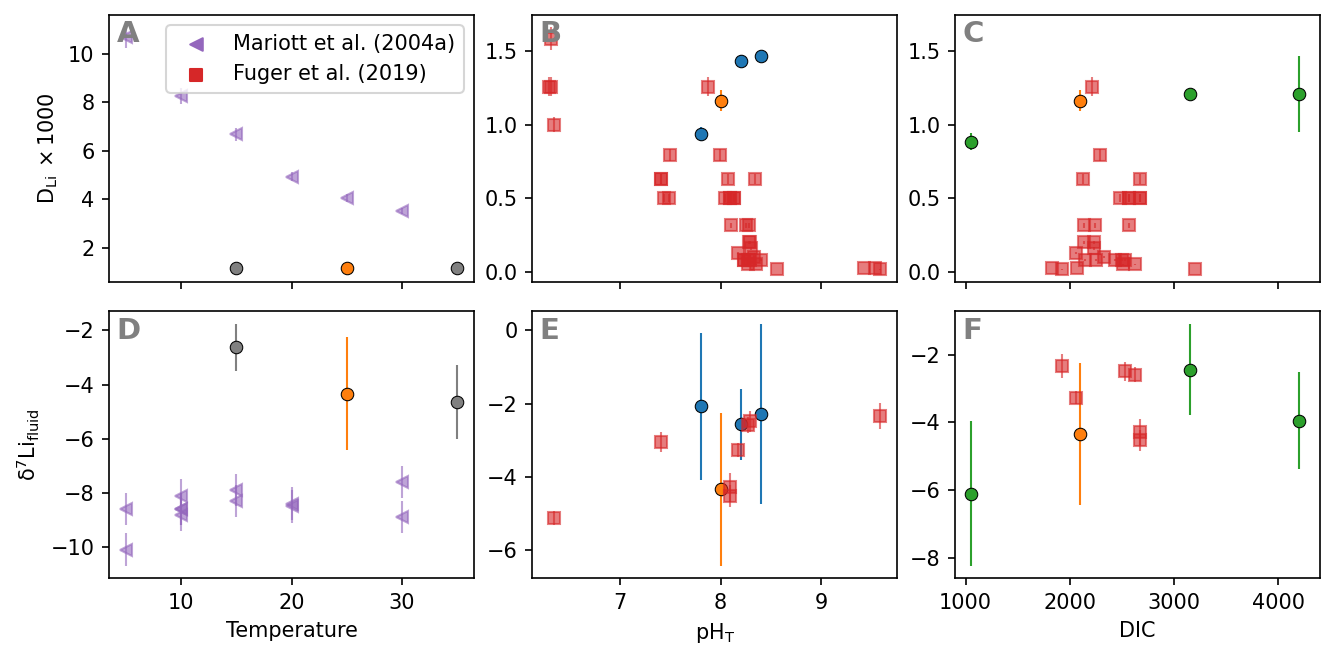

In [226]:
inorg = lit.loc['calcite']
epar = {'lw': 0,
        'elinewidth': 1,
        'alpha': 0.6}

fig, axs = plt.subplots(2, 3, sharey=False, sharex='col', figsize=[9, 4.5])

for i, xvar in enumerate(['temp(C)', 'pH', 'C(mol/kgw)']):
    dax, pax = axs.T[i]
    if xvar == 'C(mol/kgw)':
        m = 1e6
        v = 'DIC'
    elif xvar == 'pH':
        m = 1
        v = 'pH'
    elif xvar == 'temp(C)':
        m = 1
        v = 'T'
    else:
        vind = np.ones(sdf.shape[0], dtype=bool)
        m = 1

    cind = sdf.index.str.contains('Control')
    vind = sdf.index.str.contains(v)
    color = cdict[v]
    lw=0.5
    
    for ind, c in zip([vind, cind], [color, cdict['Control']]):
        dax.errorbar(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                     xerr=err(sdf.loc[ind, (database, xvar)]) * m, yerr=err(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=0, elinewidth=1, color=c, zorder=-1)
        dax.scatter(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                    lw=lw, edgecolor='k', color=c, zorder=1)
                
        pax.errorbar(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     xerr=err(sdf.loc[ind, (database, xvar)]) * m, yerr=err(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     lw=0, elinewidth=1, color=c, zorder=-1)
        pax.scatter(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                    lw=lw, edgecolor='k', color=c, zorder=1)
        

whos = ['Marriott2004a', 'Fuger2019']
for who in whos:
    c, m = mdict[who]
    
    dax, pax = axs.T[0]
    if 'Marriott' in who:
        dax.errorbar(inorg.loc[who, ('solution', 'TempC')], inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, ('solution', 'TempC')], inorg.loc[who, ('solid', 'epsilon_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'epsilon_7Li_2std')],
                     marker=m, color=c, **epar)
        
    if 'Fuger' in who:
        dax, pax = axs.T[1]
        dax.errorbar(inorg.loc[who, (database, 'pH')], inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, (database, 'pH')], inorg.loc[who, ('solid', 'epsilon_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'epsilon_7Li_2std')],
                     marker=m, color=c, **epar)
        
        dax, pax = axs.T[2]
        dax.errorbar(inorg.loc[who, (database, 'C(mol/kgw)')] * 1e6, inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, (database, 'C(mol/kgw)')] * 1e6, inorg.loc[who, ('solid', 'epsilon_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'epsilon_7Li_2std')],
                     marker=m, color=c, **epar)
#     dax, pax = axs.T[4]
#     dax.scatter(inorg.loc[who, (database, 'si_Calcite')], inorg.loc[who, ('solid', 'DLi')] * 1e3, marker=m, color=c, label=rdict[who])
#     pax.scatter(inorg.loc[who, (database, 'si_Calcite')], inorg.loc[who, ('solid', 'd7Li')], marker=m, color=c, label=rdict[who])

    axs[0,0].scatter([], [], marker=m, color=c, label=rdict[who])
                    
axs[0,0].legend(fontsize=10)

axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\delta^7Li_{fluid}$')

axs[1,0].set_xlabel('Temperature')
axs[1,1].set_xlabel('$pH_T$')
axs[1,2].set_xlabel('DIC')

# axs[1,1].set_facecolor((.9,.9,.9))
# axs[1,2].set_facecolor((.9,.9,.9))

axs[1,2].set_xlim(900, 4400)
# axs[1,4].set_xlabel('SI Calcite\n(~Rate)')

# for ax in axs[1, :]:
#     ax.set_ylim(-11, 0)

fig.tight_layout(w_pad=0.5)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

savefig(fig, '02_PublishedComparison')

## 3. Rate Plots

In [161]:
fug = inorg.loc['Fuger2019', :]
epar = {'lw': 0,
        'elinewidth': 1}

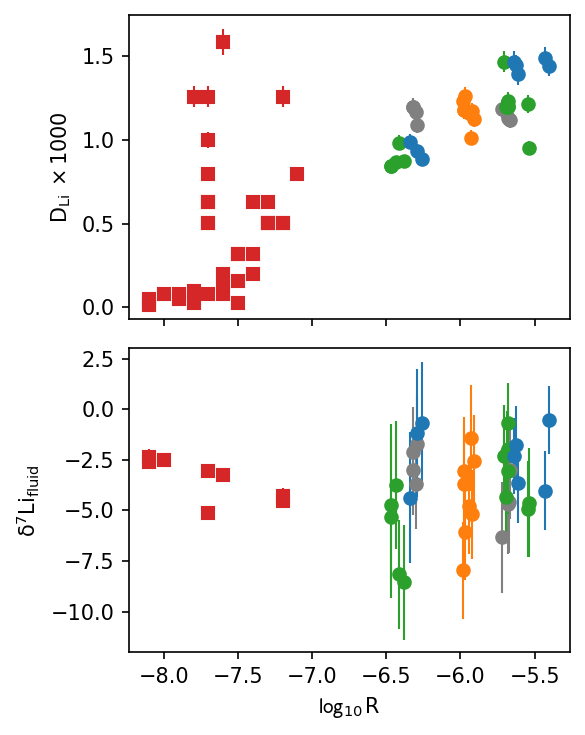

In [169]:
fig, (bax, pax) = plt.subplots(2, 1, figsize=(4, 5), sharex='col')

pax.set_xlabel('$\log_{10}R$')
bax.set_ylabel('$D_{Li}\ \\times 1000$')
pax.set_ylabel('$\delta^7Li_{fluid}$')

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, fug.loc[:, ('solid', 'DLi_2std')] * 1e3, color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')], fug.loc[:, ('solid', 'epsilon_7Li_2std')], color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)

# bax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3, 
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
# pax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)


for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    bax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                 xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                 marker='o', color=c, **epar)

    pax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 marker='o', color=c, **epar)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-12, 3)

fig.tight_layout()


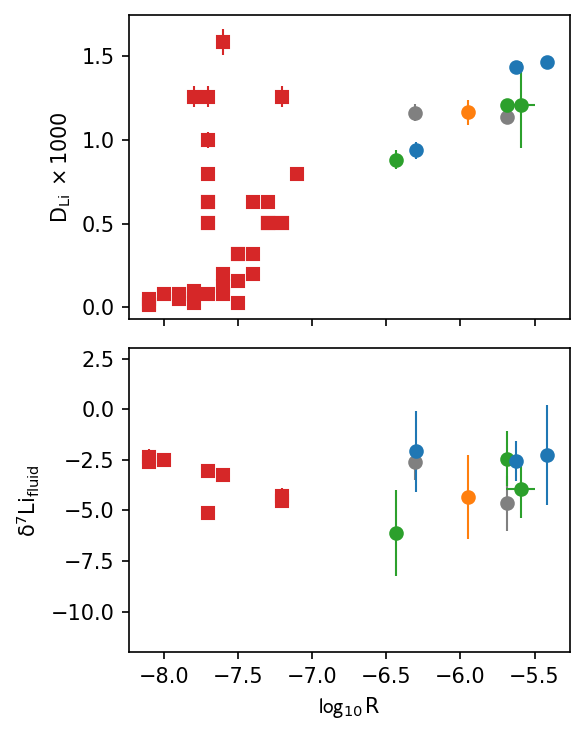

In [168]:
fig, (bax, pax) = plt.subplots(2, 1, figsize=(4, 5), sharex='col')

pax.set_xlabel('$\log_{10}R$')
bax.set_ylabel('$D_{Li}\ \\times 1000$')
pax.set_ylabel('$\delta^7Li_{fluid}$')

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, fug.loc[:, ('solid', 'DLi_2std')] * 1e3, color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')], fug.loc[:, ('solid', 'epsilon_7Li_2std')], color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)

# bax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3, 
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
# pax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)


for e, c in cdict.items():
    ind = sdf.index.str.contains(e)
    bax.errorbar(nom(sdf.loc[ind, ('R', 'log10R_13C')]), nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                 xerr=err(sdf.loc[ind, ('R', 'log10R_13C')]), yerr=err(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                 marker='o', color=c, **epar)

    pax.errorbar(nom(sdf.loc[ind, ('R', 'log10R_13C')]), nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 xerr=err(sdf.loc[ind, ('R', 'log10R_13C')]), yerr=err(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 marker='o', color=c, **epar)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-12, 3)

fig.tight_layout()


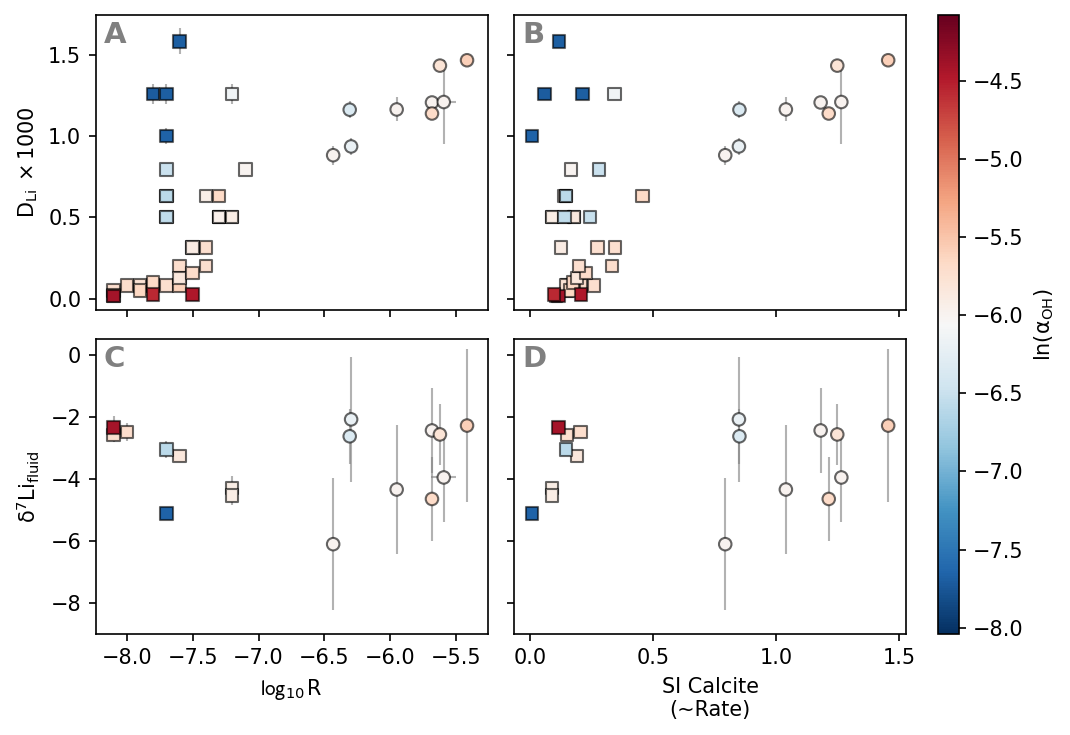

In [227]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex='col', sharey='row')

pdf = sdf
# cvar = (database, 'pH')
# clabel = cvar[-1]
cvar = (database, 'la_OH-')
clabel = r'$ln(\alpha_{OH})$'

# logR plot

bax, pax = axs[:,0]

pax.set_xlabel('$\log_{10}R$')

clim = np.concatenate([fug.loc[:, cvar].values, pdf.loc[:, cvar].values])
cargs = {
    'vmin': np.nanmin(clim) - np.ptp(clim) * 0.1,
    'vmax': np.nanmax(clim) + np.ptp(clim) * 0.1,
    'cmap': plt.cm.RdBu_r,
    'lw': 1,
    'edgecolor': (0,0,0,.6)
}

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')],
             yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
             **epar, zorder=-1, color='grey')
pax.scatter(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

pax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# SI Calcite plot

bax, pax = axs[:,1]

pax.set_xlabel('SI Calcite\n(~Rate)')

bax.errorbar(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=err(fug.loc[:, ('solid', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

pax.scatter(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'epsilon_7Li')], 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

pax.errorbar(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-9, 0.5)


axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\delta^7Li_{fluid}$')

fig.tight_layout()

fig.subplots_adjust(right=0.87)
cax = fig.add_axes([.9, pax.get_position().y0, .02, bax.get_position().y1 - pax.get_position().y0])
fig.colorbar(ma, cax, label=clabel)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

savefig(fig, '03_Rate_SI')